# Model Evaluation (Global Max Pooling)

In [1]:
import numpy as np

def load_dataset():
    X = np.load('global_max_features.npy')
    y = np.load('labels.npy')
    
    return X, y

In [2]:
X, y = load_dataset()

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def define_models(models=dict()):
    models['LogisticRegression'] = LogisticRegression()
    models['SGDClassifier'] = SGDClassifier()
    models['PassiveAggressiveClassifier'] = PassiveAggressiveClassifier()
    models['DecisionTreeClassifier'] = DecisionTreeClassifier()
    models['ExtraTreeClassifier'] = ExtraTreeClassifier()
    
    number_of_trees = 100
    models[f'AdaBoostClassifier-{number_of_trees}'] = AdaBoostClassifier(n_estimators=number_of_trees)
    models[f'BaggingClassifier-{number_of_trees}'] = BaggingClassifier(n_estimators=number_of_trees)
    models[f'RandomForestClassifier-{number_of_trees}'] = RandomForestClassifier(n_estimators=number_of_trees)
    models[f'ExtraTreesClassifier-{number_of_trees}'] = ExtraTreesClassifier(n_estimators=number_of_trees)
    models[f'GradientBoostingClassifier-{number_of_trees}'] = GradientBoostingClassifier(n_estimators=number_of_trees)
    
    number_of_neighbors = range(1, 25)
    for n in number_of_neighbors:
        models[f'KNeighborsClassifier-{n}'] = KNeighborsClassifier(n_neighbors=n)
        
    kernels = {'linear', 'poly'}
    cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for kernel in kernels:
        for c in cs:
            models[f'SCV-{kernel}-{c}'] = SVC(kernel=kernel, C=c)
        
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for alpha in alphas:
        models[f'RidgeClassifier-{alpha}'] = RidgeClassifier(alpha=alpha)
    
    print(f'Defined {len(models)} models.')

    return models

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
define_models()

Defined 64 models.


{'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'SGDClassifier': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
        n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
        shuffle=True, tol=None, verbose=0, warm_start=False),
 'PassiveAggressiveClassifier': PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
               fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
               n_jobs=1, random_state=None, shuffle=True, tol=None,
               verbose=0, warm_start=False),
 'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, c

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def make_pipeline(model):
    steps = [
        ('StandardScaler', StandardScaler()),
        ('MinMaxScaler', MinMaxScaler()),
        ('model', model)
    ]
    
    pipeline = Pipeline(steps=steps)
    
    return pipeline

In [6]:
from sklearn.model_selection import cross_val_score

def evaluate_model(X, y, model, folds, metric):
    pipeline = make_pipeline(model)
    
    return cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=4)

In [7]:
import warnings

def robust_evaluate_model(X, y, model, folds, metric):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            return evaluate_model(X, y, model, folds, metric)
    except:
        return None

In [8]:
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    
    for model_name, model in models.items():
        scores = robust_evaluate_model(X, y, model, folds, metric)
        
        if scores is not None:
            results[model_name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{model_name}: {mean_score * 100}% (+/- {std_score})')
        else:
            print(f'{model_name}: error')
    return results

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def summarize_results(results, maximize=True, top_n=10):
    if len(results) == 0:
        print('No results')
        return
    
    n = min(top_n, len(results))
    mean_scores = [(key, np.mean(value)) for key, value in results.items()]
    
    if maximize:
        mean_scores = list(reversed(mean_scores))
        
    names = [mean_score[0] for mean_score in mean_scores[:n]]
    scores = [results[mean_score[0]] for mean_score in mean_scores[:n]]
    
    print('--------')
    for index in range(n):
        name = names[index]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print(f'Rank={index + 1}, Name={name}, Score={mean_score} (+/- {std_score})')
        
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.show()

Defined 64 models.
LogisticRegression: 98.58050231476302% (+/- 0.006797389553190152)
SGDClassifier: 98.56667337612477% (+/- 0.005957516514153286)
PassiveAggressiveClassifier: 98.71694660016847% (+/- 0.0047303594740661994)
DecisionTreeClassifier: 91.7814543123178% (+/- 0.020970272504436324)
ExtraTreeClassifier: 87.6719112264144% (+/- 0.026242467107346956)
AdaBoostClassifier-100: 98.07544785632814% (+/- 0.007702413877307419)
BaggingClassifier-100: 96.10948344627587% (+/- 0.014884037698084657)
RandomForestClassifier-100: 97.18815929744518% (+/- 0.01178841004462693)
ExtraTreesClassifier-100: 96.92896920358733% (+/- 0.014018966085216225)
GradientBoostingClassifier-100: 97.95253431142321% (+/- 0.008585491307616006)
KNeighborsClassifier-1: 98.33439566419908% (+/- 0.007040876080775306)
KNeighborsClassifier-2: 97.82932256838055% (+/- 0.007286173768950057)
KNeighborsClassifier-3: 98.29354251932696% (+/- 0.006639948139257597)
KNeighborsClassifier-4: 97.96599050238932% (+/- 0.008244057417610723)
K

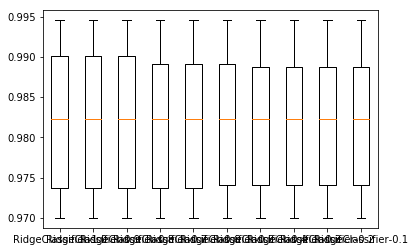

In [10]:
X, y = load_dataset()
models = define_models()
results = evaluate_models(X, y, models)
summarize_results(results)